# File Structure at Three Processing Levels for the Ocean Color Instrument (OCI)

**Authors:** Anna Windle (NASA, SSAI), Ian Carroll (NASA, UMBC), Carina Poulin (NASA, SSAI)

> **PREREQUISITES**
>
> This notebook has the following prerequisites:
> <a href="oci_data_access.html" target="_blank">OCI Data Access</a>

## Summary

In this example we will use the `earthaccess` package to access an OCI Level-1B, Level-2, and Level-3 NetCDF file and open them using `xarray`.

**NetCDF** ([Network Common Data Format][netcdf]) is a binary file format for storing multidimensional scientific data (variables). It is optimized for array-oriented data access and support a machine-independent format for representing scientific data. Files ending in `.nc` are NetCDF files.

**XArray** is a [package][xarray] that supports the use of multi-dimensional arrays in Python. It is widely used to handle Earth observation data, which often involves multiple dimensions — for instance, longitude, latitude, time, and channels/bands.

## Learning Objectives

At the end of this notebok you will know:
* How to find groups in a NetCDF file
* How to use `xarray` to open OCI data
* What key variables are present in the groups within OCI L1B, L2, and L3 files

<a name="toc"></a>
## Contents

1. [Setup](#setup)
1. [Inspecting OCI L1B File Structure](#l1b)
1. [Inspecting OCI L2 File Structure](#l2)
1. [Inspecting OCI L3 File Structure](#l3)

<a name="setup"></a>
## 1. Setup

We begin by importing all of the packages used in this notebook. If you have created an environment following the [guidance][tutorials] provided with this tutorial, then the imports will be successful.

[netcdf]: https://www.unidata.ucar.edu/software/netcdf/
[xarray]: https://docs.xarray.dev/
[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [1]:
import cartopy.crs as ccrs
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

Set (and persist to your user profile on the host, if needed) your Earthdata Login credentials.

In [2]:
auth = earthaccess.login(persist=True)

[Back to top](#toc)
<a name="l1b"></a>
## 2. Inspecting OCI L1B File Structure

Let's use `xarray` to open up a OCI L1B NetCDF file using `earthaccess`. We will use the same search method used in <a href="oci_data_access.html">OCI Data Access</a>. Note that L1B files do not include cloud coverage metadata, so we cannot use that filter.

In [3]:
tspan = ("2024-05-01", "2024-05-16")
bbox = (-76.75, 36.97, -75.74, 39.01)

results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    bounding_box=bbox,
)

Granules found: 23


In [4]:
paths = earthaccess.open(results)

Opening 23 granules, approx size: 39.77 GB
using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/23 [00:00<?, ?it/s]

We want to confirm we are running code on a remote host with direct access to the NASA Earthdata Cloud. The next cell has
no effect if we are, and otherwise raises an error. If there's an error, consider the substitution explained in the OCI Data Access notebook.

In [5]:
try:
    paths[0].f.bucket
except AttributeError:
    raise "The result opened without an S3FileSystem."

Let's open the first file of the L1B files list:

In [6]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/33)
    title:                          PACE OCI Level-1B Data
    instrument:                     OCI
    product_name:                   PACE_OCI.20240501T165311.L1B.nc
    processing_version:             V1.0
    processing_level:               L1B
    cdm_data_type:                  swath
    ...                             ...
    geospatial_lon_min:             -81.115524
    geospatial_lon_max:             -48.152897
    geospatial_bounds_crs:          EPSG:4326
    history:                        2024-05-01T19:00:18Z: l1agen_oci OCI_temp...
    time_coverage_start:            2024-05-01T16:53:11.072
    time_coverage_end:              2024-05-01T16:58:10.954

Notice that this `xarray.Dataset` has nothing but "Attributes". We cannot use `xarray` to open multi-group hierarchies or list groups within a NetCDF file, but it can open a specific group if you know its path. The `xarray-datatree` package is going to be merged into `xarray` in the not too distant future, which will allow `xarray` to open the entire hieerarchy. In the meantime, we can use a lower level reader to see the top-level groups.

In [7]:
with h5netcdf.File(paths[0]) as file:
    groups = list(file)
groups

['sensor_band_parameters',
 'scan_line_attributes',
 'geolocation_data',
 'navigation_data',
 'observation_data']

Let's open the "observation_data" group, which contains the core science variables.

In [8]:
dataset = xr.open_dataset(paths[0], group="observation_data")
dataset

<xarray.Dataset> Size: 5GB
Dimensions:    (blue_bands: 119, number_of_scans: 1710, ccd_pixels: 1272,
                red_bands: 163, SWIR_bands: 9, SWIR_pixels: 1272)
Dimensions without coordinates: blue_bands, number_of_scans, ccd_pixels,
                                red_bands, SWIR_bands, SWIR_pixels
Data variables:
    rhot_blue  (blue_bands, number_of_scans, ccd_pixels) float32 1GB ...
    qual_blue  (blue_bands, number_of_scans, ccd_pixels) float32 1GB ...
    rhot_red   (red_bands, number_of_scans, ccd_pixels) float32 1GB ...
    qual_red   (red_bands, number_of_scans, ccd_pixels) float32 1GB ...
    rhot_SWIR  (SWIR_bands, number_of_scans, SWIR_pixels) float32 78MB ...
    qual_SWIR  (SWIR_bands, number_of_scans, SWIR_pixels) float32 78MB ...

Now you can view the Dimensions, Coordinates, and Variables of this group. To show/hide attributes, press the paper icon on the right hand side of each variable. To show/hide data representation, press the cylinder icon. For instance, you could check the attributes on "rhot_blue" to see that this variable is the "Top of Atmosphere Blue Band Reflectance".

The dimensions of the "rhot_blue" variable are ("blue_bands", "number_of_scans", "ccd_pixels"), and it has shape (119, 1709, 1272). The `sizes` attribute of a variable gives us that information as a dictionary.

In [9]:
dataset["rhot_blue"].sizes

Frozen({'blue_bands': 119, 'number_of_scans': 1710, 'ccd_pixels': 1272})

Let's plot the reflectance at postion 100 in the "blue_bands" dimension.

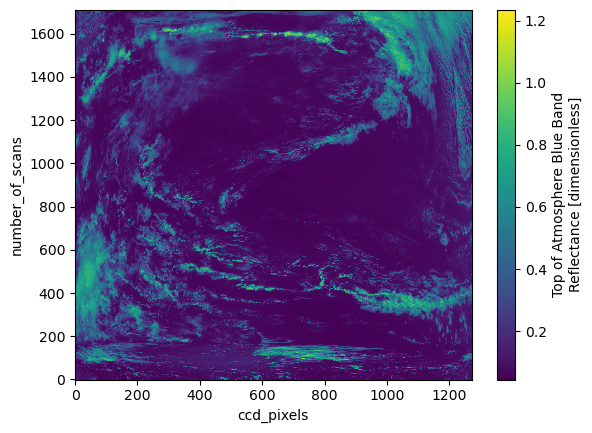

In [10]:
plot = dataset["rhot_blue"].sel({"blue_bands": 100}).plot()

[Back to top](#toc)
<a name="l2"></a>
## 3. Inspecting OCI L2 File Structure

OCI L2 files include retrievals of geophysical variables, such as Apparent Optical Properties (AOP), for each L1 swath. We'll use the same `earthaccess` search for L2 AOP data. Although now we can use `cloud_cover` too.

In [11]:
tspan = ("2024-05-01", "2024-05-16")
bbox = (-76.75, 36.97, -75.74, 39.01)
clouds = (0, 50)

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

Granules found: 3


In [12]:
paths = earthaccess.open(results)

Opening 3 granules, approx size: 1.22 GB
using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
with h5netcdf.File(paths[0]) as file:
    groups = list(file)
groups

['sensor_band_parameters',
 'scan_line_attributes',
 'geophysical_data',
 'navigation_data',
 'processing_control']

Let's look at the "geophysical_data" group, which is a new group generated by the level 2 processing.

In [14]:
dataset = xr.open_dataset(paths[0], group="geophysical_data")
rrs = dataset["Rrs"]
rrs

<xarray.DataArray 'Rrs' (number_of_lines: 1709, pixels_per_line: 1272,
                         wavelength_3d: 184)> Size: 2GB
[399988032 values with dtype=float32]
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

In [15]:
rrs.sizes

Frozen({'number_of_lines': 1709, 'pixels_per_line': 1272, 'wavelength_3d': 184})

The Rrs variable has length 184 in the wavelength dimension, so the blue, red, and SWIR wavelengths have been combined. Let's map the Rrs at "wavelength_3d" position 100.

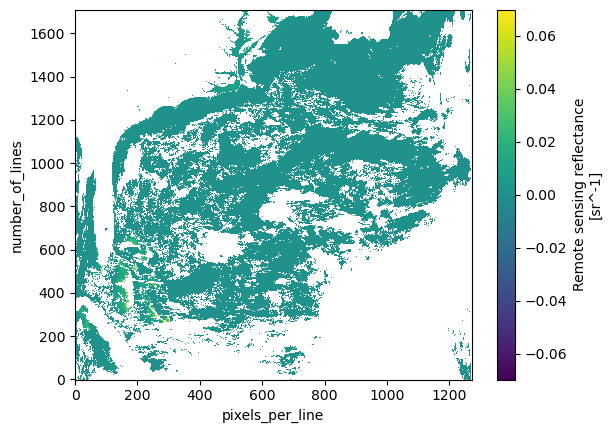

In [16]:
plot = rrs.sel({"wavelength_3d": 100}).plot(cmap="viridis")

Right now, the scene is being plotted using `number_of_lines` and `pixels_per_line` as "x" and "y", respectively. We need to add latitude and longitude values to create a true map. To do this, we will create a merged `xarray.Dataset` that pulls in information from the "navigation_data" group.

In [17]:
dataset = xr.open_dataset(paths[0], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = dataset.rename({"pixel_control_points": "pixels_per_line"})
dataset = xr.merge((rrs, dataset.coords))
dataset

<xarray.Dataset> Size: 2GB
Dimensions:    (number_of_lines: 1709, pixels_per_line: 1272, wavelength_3d: 184)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB ...
    latitude   (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs        (number_of_lines, pixels_per_line, wavelength_3d) float32 2GB ...
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

Although we now have coordinates, they won't immediately help because the data are not gridded by latitude and longitude.
The Level 2 data cover the original instrument swath and have not been resampled to a regular grid. Therefore latitude
and longitude are known, but cannot be used immediately to "look-up" values like you can along an array's dimensions.

Let's make a scatter plot of the pixel locations so we can see the irregular spacing. By selecting a `slice` with a step size larger than one, we get a subset of the locations for better visualization.

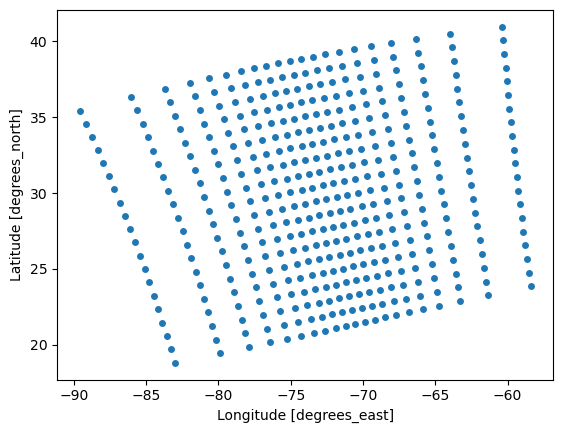

In [18]:
plot = dataset.sel(
    {
        "number_of_lines": slice(None, None, 1720 // 20),
        "pixels_per_line": slice(None, None, 1272 // 20),
    },
).plot.scatter(x="longitude", y="latitude")

Let's plot this new `xarray.Dataset` the same way as before, but add latitude and longitude.

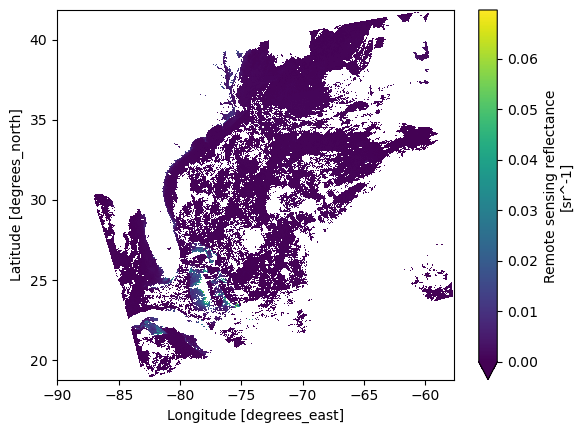

In [19]:
rrs = dataset["Rrs"].sel({"wavelength_3d": 100})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0)

Now you can project the data onto a grid. If you wanna get fancy, add a coastline.

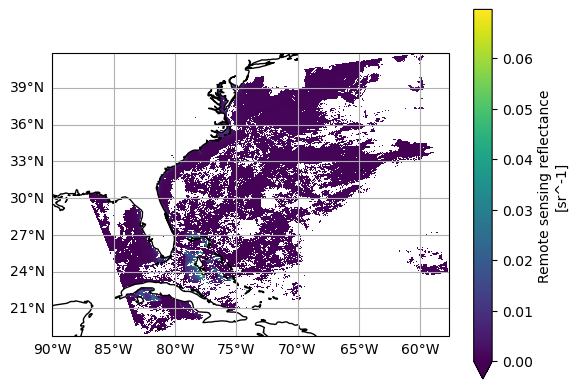

In [20]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0, ax=ax)

Let's plot the full "Rrs" spectrum for individual pixels. A visualization with all the pixels
wouldn't be useful, but limiting to a bounding box gives a simple way to subset pixels. Note that,
since we still don't have gridded data (i.e. our latitude and longitude coordinates are two-dimensional),
we can't `slice` on a built-in index. Without getting into anything complex, we can just box it out.

In [21]:
rrs_box = dataset["Rrs"].where(
    (
        (dataset["latitude"] > 37.52)
        & (dataset["latitude"] < 37.55)
        & (dataset["longitude"] > -75.46)
        & (dataset["longitude"] < -75.43)
    ),
    drop=True,
)
rrs_box.sizes

Frozen({'number_of_lines': 3, 'pixels_per_line': 3, 'wavelength_3d': 184})

The line plotting method will only draw a line plot for 1D data, which we can get by stacking
our two spatial dimensions and choosing to show the new "pixel dimension" as different colors.

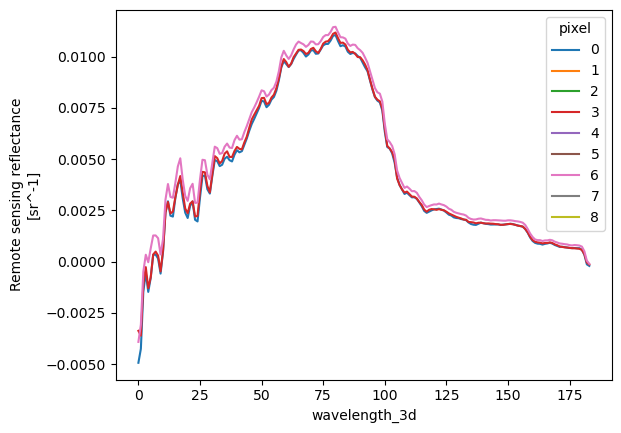

In [22]:
rrs_stack = rrs_box.stack(
    {"pixel": ["number_of_lines", "pixels_per_line"]},
    create_index=False,
)
plot = rrs_stack.plot.line(hue="pixel")

We will go over how to plot Rrs spectra with accurate wavelength values on the x-axis in an upcoming notebook.

[Back to top](#toc)
<a name="l3"></a>
## 4. Inspecting OCI L3 File Structure

At Level-3 there are binned (B) and mapped (M) products available for OCI. The L3M remote sensing reflectance (Rrs) files contain global maps of Rrs. We'll use the same `earthaccess` method to find the data.

In [23]:
tspan = ("2024-05-01", "2024-05-16")
bbox = (-76.75, 36.97, -75.74, 39.01)

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

Granules found: 120


In [24]:
paths = earthaccess.open(results)

Opening 120 granules, approx size: 36.62 GB
using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/120 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/120 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/120 [00:00<?, ?it/s]

OCI L3 data do not have any groups, so we can open the dataset without the `group` argument.
Let's take a look at the first file.

In [25]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 149MB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs_442  (lat, lon) float32 149MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240430_20240507.L3m.8D.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/v1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         15522789
    data_minimum:                      -0.0009940007
    data_maximum:                      0.09647354

Notice that OCI L3M data has `lat` and `lon` coordinates, so it's easy to slice out a bounding box and map the "Rrs_442" variable.

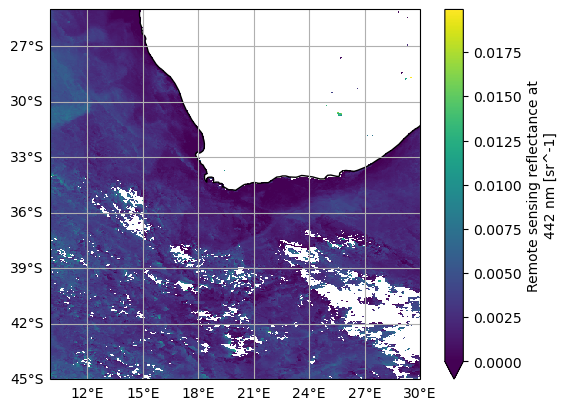

In [26]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

rrs_442 = dataset["Rrs_442"].sel({"lat": slice(-25, -45), "lon": slice(10, 30)})
plot = rrs_442.plot(cmap="viridis", vmin=0, ax=ax)

Also becuase the L3M variables have `lat` and `lon` coordinates, it's possible to stack multiple granules along a
new dimension that corresponds to time.
Instead of `xr.open_dataset`, we use `xr.open_mfdataset` to create a single `xarray.Dataset` (the "mf" in `open_mfdataset` stands for multiple files) from an array of paths.

We also use a new search filter available in `earthaccess.search_data`: the `granule_name` argument accepts strings with the "*" wildcard. We need this to distinguish daily ("DAY") from eight-day ("8D") composites, as well as to get the 0.1 degree resolution projections.

In [27]:
tspan = ("2024-05-01", "2024-05-8")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

Granules found: 8


In [28]:
paths = earthaccess.open(results)

Opening 8 granules, approx size: 0.03 GB
using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

The `paths` list is sorted temporally by default, which means the shape of the `paths` array specifies the way we need to tile the files together into larger arrays. We specify `combine="nested"` to combine the files according to the shape of the array of files (or file-like objects), even though `paths` is not a "nested" list in this case. The `concat_dim="date"` argument generates a new dimension in the combined dataset, because "date" is not an existing dimension in the individual files.

In [29]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)

Add a date dimension using the dates from the netCDF files.

In [30]:
dates = [ xr.open_dataset(a).attrs["time_coverage_end"] for a in paths]
dt = pd.to_datetime(dates)
dataset = dataset.assign_coords(date=dt.values)
dataset

<xarray.Dataset> Size: 207MB
Dimensions:  (date: 8, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date     (date) datetime64[ns] 64B 2024-05-02T02:28:09 ... 2024-05-09T01:...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 207MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 6kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240501.L3m.DAY.CHL.V1_0_0.c...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/v1
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         1029726
    data_minimum:                      0.0041330624
    data_maximum:                      95.82805

A common reason to generate a single dataset from multiple, daily images is to create a composite. Compare the map from a single day ...

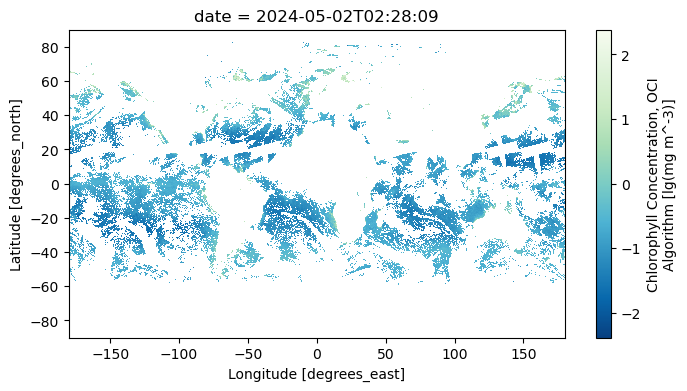

In [31]:
chla = np.log10(dataset["chlor_a"])
chla.attrs.update(
    {
        "units": f'lg({dataset["chlor_a"].attrs["units"]})',
    }
)
plot = chla.sel(date = "2024-05-02").plot(aspect=2, size=4, cmap="GnBu_r")

... to a map of average values, skipping "NaN" values that result from clouds and the OCI's tilt maneuver.

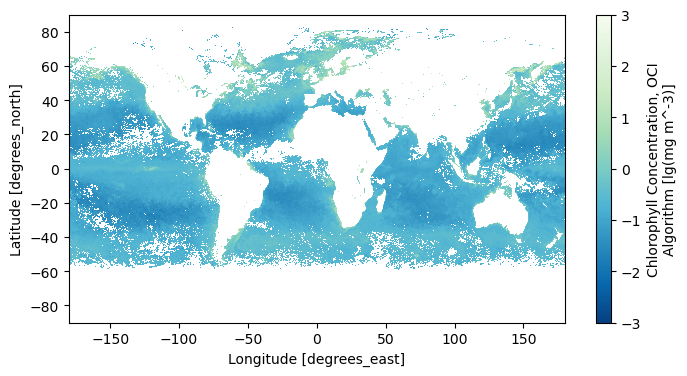

In [32]:
chla_avg = chla.mean("date")
chla_avg.attrs.update(
    {
        "long_name": chla.attrs["long_name"],
        "units": chla.attrs["units"],
    }
)
plot = chla_avg.plot(aspect=2, size=4, cmap="GnBu_r")

We can also create a time series of mean values over the whole region.

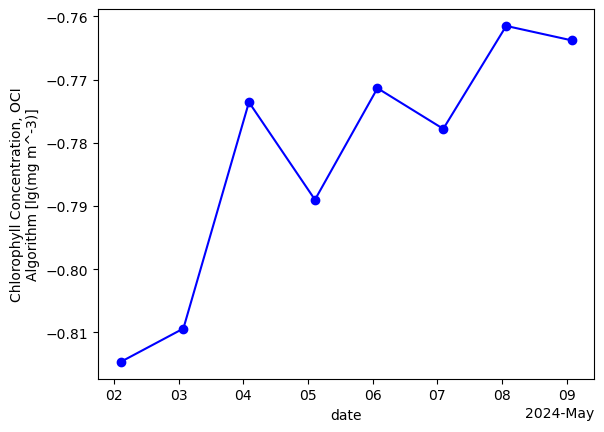

In [33]:
chla_avg = chla.mean(dim=["lon", "lat"], keep_attrs=True)
plot = chla_avg.plot(linestyle='-', marker='o', color='b')

<div class="alert alert-info" role="alert">
<p>You have completed the notebook on OCI file structure.</p>
</div>